# Weight decay and Normal equation

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PilotLeoYan/inside-deep-learning/blob/main/1-linear-regression/weight-decay-and-normal-equation.ipynb">
    <img src="../images/colab_logo.png" width="32">Open in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://nbviewer.org/github/PilotLeoYan/inside-deep-learning/blob/main/1-linear-regression/weight-decay-and-normal-equation.ipynb">
    <img src="../images/jupyter_logo.png" width="32">Open in Jupyter NBViewer</a>
  </td>
</table>

In this notebook we will visualize the effects of weight decay (or also called L2 regularizer) 
on the objective function $J$. When our model tries to minimize $J$, 
we see that the minimum of the function has moved from the minimum of the loss function. 
This means that the model is learning poorly to fit the training data, this can be useful to avoid overfitting.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from platform import python_version
python_version()

'3.13.5'

In [2]:
import os
import sys
import requests
import importlib.util
from collections.abc import Callable

def import_mape(module_path: str = '..') -> Callable:
    """
    Tries to import the 'numpy_mape' function from a local project structure.
    If it fails (ModuleNotFoundError), it assumes a cloud environment (like Colab),
    downloads the module from GitHub, imports it, and returns the function.

    Args:
        module_path (str): The relative path to the project's root directory
                           for the local search.

    Returns:
        The imported 'numpy_mape' function, or None if it fails.
    """
    GITHUB_RAW_URL = 'https://raw.githubusercontent.com/PilotLeoYan/inside-deep-learning/main/tools/numpy_metrics.py'
    MODULE_NAME = 'numpy_metrics'
    LOCAL_FILE_NAME = f'{MODULE_NAME}.py'

    try:
        # Attempt 1: Standard import (if the package is installed or in PYTHONPATH)
        from tools.numpy_metrics import np_mape
        print("✅ Module 'tools.numpy_metrics' successfully imported from the environment.")
        return np_mape

    except ModuleNotFoundError:
        # Attempt 2: Search in the specified local path (original behavior)
        # This is useful for local development without installing the package.
        project_path = os.path.abspath(os.path.join(module_path))
        if project_path not in sys.path:
            sys.path.insert(0, project_path)

        try:
            from tools.numpy_metrics import np_mape
            print("✅ Local module 'tools.numpy_metrics' imported after adjusting the path.")
            # Remove the added path to avoid side effects
            sys.path.pop(0)
            return np_mape
        except ModuleNotFoundError:
            # If both local attempts fail, proceed with the download
            if project_path in sys.path:
                sys.path.pop(0) # Clean up the path if it was added
            print(f"⚠️ Local module not found. Proceeding to download from GitHub...")

    # Download and Dynamic Loading Logic}
    if not os.path.exists(LOCAL_FILE_NAME):
        try:
            print(f"⬇️ Downloading '{LOCAL_FILE_NAME}' from GitHub...")
            response = requests.get(GITHUB_RAW_URL)
            response.raise_for_status()  # This will raise an error if the HTTP request failed
            with open(LOCAL_FILE_NAME, "w", encoding="utf-8") as f:
                f.write(response.text)
            print("👍 Download complete.")
        except requests.exceptions.RequestException as e:
            print(f"❌ Error downloading the file: {e}")
            return None

    # Dynamically load the module using importlib
    spec = importlib.util.spec_from_file_location(MODULE_NAME, LOCAL_FILE_NAME)
    dynamic_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dynamic_module)
    
    print(f"✅ Module '{MODULE_NAME}' successfully loaded from the downloaded file.")
    return dynamic_module.np_mape

In [3]:
mape = import_mape()

✅ Local module 'tools.numpy_metrics' imported after adjusting the path.


# Dataset

## create dataset

In [4]:
M: int = 1_000 # number of samples
N: int = 1 # number of input features

X = np.random.randn(M, N)
True_W = np.array([[3.14]])
Y = X @ True_W + 1.0

X.shape, Y.shape

((1000, 1), (1000, 1))

# Linear Least Squares

## problem statement

Least squares
$$
\text{LS}(\mathbf{w}) = \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

In [5]:
def least_squares(w: np.ndarray) -> np.float64:
    return np.sum(np.square(X @ w - Y)) / 2

Problem to solve
$$
\min_{\mathbf{w}} \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

But, we are interested in finding $\mathbf{w}$ that minimizes the least squares.
Then, we are looking for
$$
\mathbf{w}^{*} = \underset{\mathbf{w}}{\text{arg min}} \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
$$

## normal equation

$$
\nabla_{\mathbf{w}}\text{LS} = \mathbf{X^{\top}} (\mathbf{Xw - y})
$$

If we equal it to 0 (zero vector) to find the minimum of least squares
$$
\nabla_{\mathbf{w}}\text{LS} = \mathbf{0} \\
\mathbf{X^{\top}} (\mathbf{Xw - y}) = \mathbf{0} \\
\mathbf{X^{\top}Xw - X^{\top}y = 0} \\
\mathbf{X^{\top}Xw} = \mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X}\right)^{-1}\mathbf{X^{\top}y}
$$

In [6]:
w_ls = np.linalg.inv(X.T @ X) @ X.T @ Y
w_ls.shape

(1, 1)

In [7]:
least_squares(w_ls)

np.float64(499.80971858333845)

In [8]:
w_ls

array([[3.12021532]])

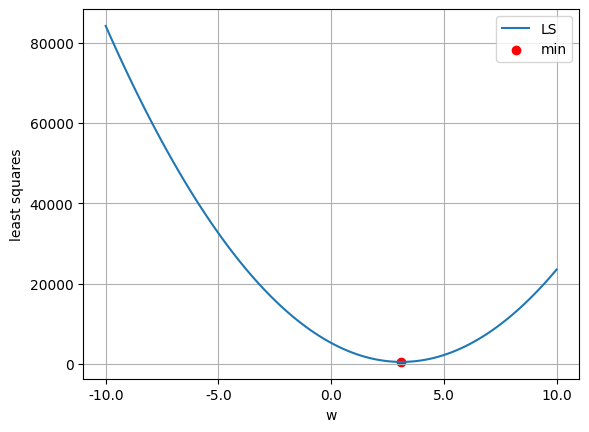

In [9]:
w_values = np.linspace(-10, 10, 100)
ls_values = np.array([least_squares(w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='LS')
plt.scatter(w_ls.item(), least_squares(w_ls).item(), color='red', label='min')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.legend()
plt.xlabel('w')
plt.ylabel('least squares')
plt.grid(True)
plt.show()

## what happens if we use MSE loss?

Our typical MSE loss function is
$$
\begin{align*}
\text{MSE}(\mathbf{w}) &= \frac{1}{m} \sum_{i=1}^{m} \left(
    \mathbf{x}_{i,:} \mathbf{w - y}
\right)^{2} \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2} \\
&= \frac{2}{m} \text{LS}(\mathbf{w})
\end{align*}
$$

In [10]:
def mse_loss(w: np.ndarray) -> np.float64:
    return np.mean(np.square(X @ w - Y))

In [11]:
mape(
    mse_loss(w_ls),
    least_squares(w_ls) * 2 / M
).item()

0.0

Why does the normal least squares equation also minimize the MSE loss?
The gradient of MSE is
$$
\nabla_{\mathbf{w}}\text{MSE} = \frac{2}{m} \mathbf{X^{\top}(X^{\top}w - y)}
$$

$$
\nabla_{\mathbf{w}}\text{MSE} = \mathbf{0} \\
\frac{2}{m}\mathbf{X^{\top}} (\mathbf{Xw - y}) = \mathbf{0} \\
\frac{2}{m}\mathbf{X^{\top}Xw} - \frac{2}{m}\mathbf{X^{\top}y = 0} \\
\frac{2}{m}\mathbf{X^{\top}Xw} = \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\frac{2}{m} \mathbf{X^{\top}X}\right)^{-1} \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\frac{2}{m}\right)^{-1}\left(\mathbf{X^{\top}X}\right)^{-1} \frac{2}{m}\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X}\right)^{-1} \mathbf{X^{\top}y} \\
$$

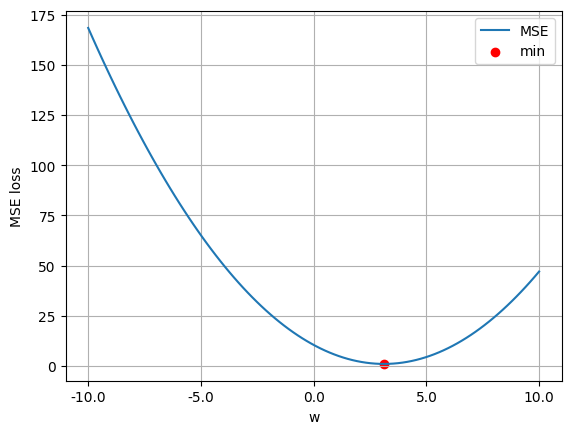

In [12]:
w_values = np.linspace(-10, 10, 100)
ls_values = np.array([mse_loss(w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='MSE')
plt.scatter(w_ls.item(), mse_loss(w_ls).item(), color='red', label='min')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.legend()
plt.xlabel('w')
plt.ylabel('MSE loss')
plt.grid(True)
plt.show()

# LS + weight decay

## problem statement

Weight decay or L2 regularizer
$$
\ell_{2}(\mathbf{w}) = \frac{\lambda}{2}\|\mathbf{w}\|^{2}_{2}
$$
where $\lambda \in \mathbb{R}$ is a hyperparameter.

In [13]:
def weight_decay(lambd: float, w: np.ndarray) -> np.float64:
    return np.sum(np.square(w)) * lambd / 2

Objective function
$$
\begin{align*}
J_{\text{LS}}(\mathbf{w}) &= \text{LS}(\mathbf{w}) + \ell_{2}(\mathbf{w}) \\
&= \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\end{align*}
$$

In [14]:
def objective_ls(lambd: float, w: np.ndarray) -> np.float64:
    return least_squares(w) + weight_decay(lambd, w)

Problem to solve
$$
\min_{\mathbf{w}} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

We are looking
$$
\mathbf{w}^{*} = \underset{\mathbf{w}}{\text{arg min}} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

## closed form

$$
\nabla_{\mathbf{w}}J_{\text{LS}} = \mathbf{X^{\top}} (\mathbf{Xw - y})
+ \lambda_{1} \mathbf{w}
$$

$$
\nabla_{\mathbf{w}}J_{\text{LS}} =\mathbf{0} \\
\mathbf{X^{\top}} (\mathbf{Xw - y}) + \lambda_{1} \mathbf{w} = \mathbf{0} \\
\mathbf{X^{\top}Xw} + \lambda_{1}  \mathbf{w} - \mathbf{X^{\top}y} = \mathbf{0} \\
(\mathbf{X^{\top}X} + \lambda_{1}  \boldsymbol{I}) \mathbf{w} = \mathbf{X^{\top}y} \\
\mathbf{w} = (\mathbf{X^{\top}X} + \lambda_{1}  \boldsymbol{I})^{-1} \mathbf{X^{\top}y} \\
$$

In [15]:
LAMBDA: float = 1e3

In [16]:
w_ls_l2 = np.linalg.inv(X.T @ X + (LAMBDA * np.identity(N))) @ X.T @ Y
w_ls_l2.shape

(1, 1)

In [17]:
objective_ls(LAMBDA, w_ls_l2).item(), least_squares(w_ls_l2).item()

(2899.4721935673633, 1716.5363610685572)

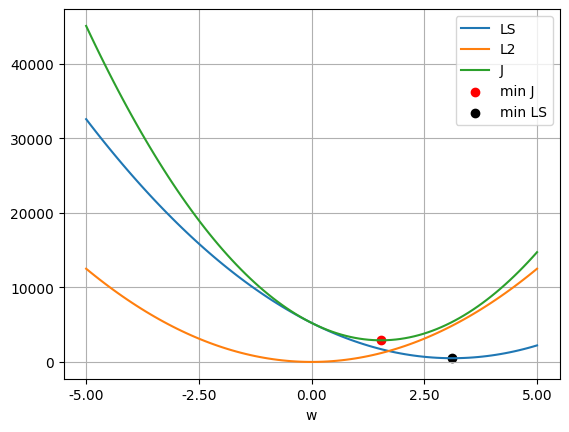

In [18]:
w_values = np.linspace(-5, 5, 100)
ls_values = np.array([least_squares(w.reshape(-1, 1)) for w in w_values])
wd_values = np.array([weight_decay(LAMBDA, w.reshape(-1, 1)) for w in w_values])
j_values = np.array([objective_ls(LAMBDA, w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, ls_values, label='LS')
plt.plot(w_values, wd_values, label='L2')
plt.plot(w_values, j_values, label='J')
plt.scatter(w_ls_l2.item(), objective_ls(LAMBDA, w_ls_l2).item(), color='red', label='min J')
plt.scatter(w_ls.item(), least_squares(w_ls).item(), color='black', label='min LS')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.legend()
plt.xlabel('w')
plt.grid(True)
plt.show()

# MSE + weight decay

## problem statement

Objective function
$$
J_{\text{MSE}}(\mathbf{w}) = \text{MSE}(\mathbf{w}) + \ell_{2}(\mathbf{w})
$$

In [19]:
def objective_mse(lambd: float, w: np.ndarray) -> np.float64:
    return mse_loss(w) + weight_decay(lambd, w)

Problem to solve
$$
\min_{\mathbf{w}} \left(
    \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

We are looking
$$
\mathbf{w}^{*} = \underset{\mathbf{w}}{\text{arg min}} \left(
    \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2}
\right)
$$

## closed form

$$
\nabla_{\mathbf{w}}J_{\text{MSE}} = \frac{2}{m}
\mathbf{X^{\top}} (\mathbf{Xw - y})
+ \lambda_{2} \mathbf{w}
$$

$$
\nabla_{\mathbf{w}}J_{\text{MSE}} =\mathbf{0} \\
\frac{2}{m} \mathbf{X^{\top}} (\mathbf{Xw - y}) + \lambda_{2} \mathbf{w} = \mathbf{0} \\
\frac{2}{m} \mathbf{X^{\top}Xw} + \lambda_{2} \mathbf{w} - \frac{2}{m} \mathbf{X^{\top}y} = \mathbf{0} \\
\left(\frac{2}{m} \mathbf{X^{\top}X} + \lambda_{2} \boldsymbol{I} \right) \mathbf{w} = \frac{2}{m} \mathbf{X^{\top}y} \\
\mathbf{w} = \frac{2}{m} \left(\frac{2}{m} \mathbf{X^{\top}X} + \lambda_{2} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
$$

if we use the value of $\lambda_{1}$ used in least squares
$$
\lambda_{2} = \frac{2 \lambda_{1}}{m} 
$$
then, we get the following solution
$$
\mathbf{w} = \frac{2}{m} \left(\frac{2}{m} \mathbf{X^{\top}X} + \frac{2 \lambda_{1}}{m} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
\mathbf{w} = \frac{2}{m} \left( \frac{2}{m}
    \left(
        \mathbf{X^{\top}X} + \lambda_{1} \boldsymbol{I}
    \right) 
\right)^{-1} 
\mathbf{X^{\top}y} \\
\mathbf{w} = \left(\mathbf{X^{\top}X} + \lambda_{1} \boldsymbol{I} \right)^{-1} 
\mathbf{X^{\top}y} \\
$$
the same least squares solution with weight decay.

In [20]:
LAMBDA2 = 2 * LAMBDA / M
LAMBDA2

2.0

In [21]:
w_mse_l2 = 2 * np.linalg.inv((2 * X.T / M) @ X + (LAMBDA2 * np.identity(N))) @ X.T @ Y / M
w_mse_l2.shape

(1, 1)

In [22]:
mape(w_mse_l2, w_ls_l2) # both solutions are similar

1.4435925562788924e-14

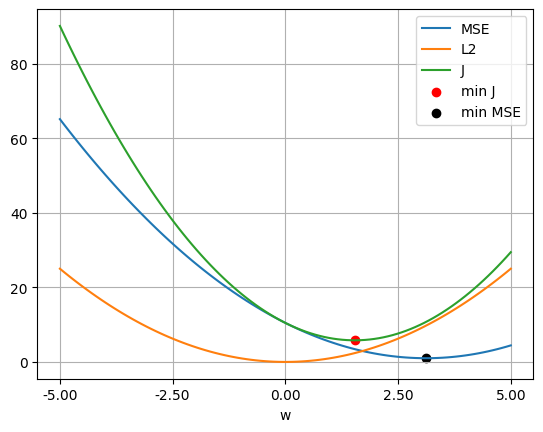

In [23]:
w_values = np.linspace(-5, 5, 100)
mss_values = np.array([mse_loss(w.reshape(-1, 1)) for w in w_values])
wd_values = np.array([weight_decay(LAMBDA2, w.reshape(-1, 1)) for w in w_values])
j_values = np.array([objective_mse(LAMBDA2, w.reshape(-1, 1)) for w in w_values])

plt.plot(w_values, mss_values, label='MSE')
plt.plot(w_values, wd_values, label='L2')
plt.plot(w_values, j_values, label='J')
plt.scatter(w_mse_l2.item(), objective_mse(LAMBDA2, w_mse_l2).item(), color='red', label='min J')
plt.scatter(w_ls.item(), mse_loss(w_ls).item(), color='black', label='min MSE')
plt.xticks(np.linspace(w_values[0], w_values[-1], 5))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.legend()
plt.xlabel('w')
plt.grid(True)
plt.show()

If we use $\lambda_{1} = \frac{m \lambda_{2}}{2}$, then
$$
\begin{align*}
J_{\text{MSE}}(\mathbf{w}) &= \frac{2}{m} J_\text{LS}(\mathbf{w}) \\
&= \frac{2}{m} \left(
    \frac{1}{2} \|\mathbf{Xw - y}\|^{2}_{2}
    + \frac{\lambda_{1}}{2}\|\mathbf{w}\|^{2}_{2}
\right) \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{1}}{m}\|\mathbf{w}\|^{2}_{2} \\
&= \frac{1}{m} \|\mathbf{Xw - y}\|^{2}_{2}
+ \frac{\lambda_{2}}{2}\|\mathbf{w}\|^{2}_{2} \\
&= \text{MSE}(\mathbf{w}) + \ell_{2}(\mathbf{w})
\end{align*}
$$
Therefore, least squares and MSE are the same when we scale the $\lambda$ value.

In [24]:
mape(
    objective_mse(2 * LAMBDA / M, w_ls), # remember that LAMBDA2 := 2 * LAMBDA / M
    objective_ls(LAMBDA, w_ls) * 2 / M
).item()

0.0

# Example with $\mathbf{w} \in \mathbb{R}^{2}$

In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [26]:
X = np.random.randn(M, 2)
True_W_2 = np.array([[4.0], [1.5]])
Y = X @ True_W_2

X.shape, Y.shape

((1000, 2), (1000, 1))

In [27]:
LAMBDA3 = 1e3
w_2 = np.linalg.inv(X.T @ X + LAMBDA3 * np.identity(2)) @ X.T @ Y
w_2

array([[2.08671224],
       [0.73766532]])

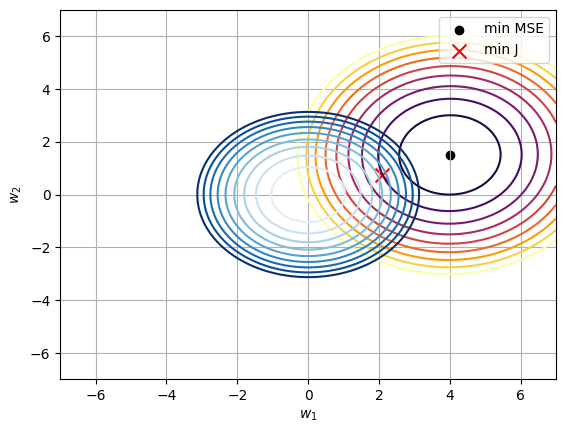

In [28]:
w1_values = np.linspace(-7, 7, 100)
w2_values = np.linspace(-7, 7, 100)
W1_values, W2_values = np.meshgrid(w1_values, w2_values)
mse_values = np.array([[mse_loss(np.array([[w1], [w2]])) for w1 in w1_values] for w2 in w2_values])
wd_values = np.array([[weight_decay(LAMBDA3, np.array([[w1], [w2]])) for w1 in w1_values] for w2 in w2_values])

plt.contour(W1_values, W2_values, mse_values, cmap='inferno',
            levels=np.linspace(np.min(mse_values) * 0.1, np.max(mse_values) * 0.1, 10))
plt.scatter(True_W_2[0, 0], True_W_2[1, 0], color='black', label='min MSE')
plt.contour(W1_values, W2_values, wd_values, cmap='Blues',
            levels=np.linspace(np.min(wd_values) * 0.1, np.max(wd_values) * 0.1, 10))
plt.scatter(w_2[0, 0], w_2[1, 0], marker='x', color='red', s=100, label='min J')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.grid(True)
plt.xlabel('$w_{1}$')
plt.ylabel('$w_{2}$')
plt.legend()
plt.show()

We can see that both functions have an oval shape because 
$w_{1}$ has a greater influence than $w_{2}$.

# What if $\mathbf{Y} \in \mathbb{R}^{m \times n_{1}}$?

MSE loss function
$$
\text{MSE}(\mathbf{W}) = \frac{1}{mn} \text{sum} \left( \left(
    \mathbf{XW - Y}
\right)^{2} \right)
$$
where $\mathbf{A}^{2} = \mathbf{A} \odot \mathbf{A}$.

weight decay function
$$
\ell_{2}(\mathbf{W}) = \frac{\lambda}{2} \text{sum} \left(
    \mathbf{W}^{2}
\right)
$$

Our objetive function
$$
J(\mathbf{W}) = \text{MSE}(\mathbf{W}) + \ell_{2}(\mathbf{W})
$$

the gradient of $J$
$$
\nabla_{\mathbf{W}} J = \frac{2}{mn} \mathbf{X}^{\top} \left(
    \mathbf{XW - Y}
\right) + \lambda \mathbf{W}
$$

then, its closed form
$$
\mathbf{W} = \frac{2}{mn} \left(
    \frac{2}{mn} \mathbf{X^{\top} X} + \lambda \boldsymbol{I}
\right)^{-1} \mathbf{X^{\top} Y}
$$

if we apply $\lambda \leftarrow \frac{2}{mn} \lambda$, therefore
$$
\mathbf{W} = \left(
    \mathbf{X^{\top} X} + \lambda \boldsymbol{I}
\right)^{-1} \mathbf{X^{\top} Y}
$$